# Test PHYSLITE Combination

This notebook will test ideas for combining the calibrated values from PHYSLITE and the uncalibrated values from LLP1.

* Should be faster than running calibrations of LLP1
* Will be an in-memory test, which likely won't work for the full dataset.

The datasets we'll use:

In [ ]:
did_LLP1 = "mc23_13p6TeV:mc23_13p6TeV.802746.Py8EG_Zprime2EJs_Ld20_rho40_pi10_Zp2600_l1.deriv.DAOD_LLP1.e8531_s4159_r15530_p6463"
did_PHYSLITE = "mc23_13p6TeV:mc23_13p6TeV.802746.Py8EG_Zprime2EJs_Ld20_rho40_pi10_Zp2600_l1.deriv.DAOD_PHYSLITE.e8531_s4159_r15530_p6491"

## Imports

In [1]:
import awkward as ak
import numpy as np
from func_adl_servicex_xaodr25 import FuncADLQueryPHYSLITE
from servicex import Sample, ServiceXSpec, dataset, deliver
from servicex_analysis_utils import to_awk

from calratio_training_data import RunConfig, fetch_training_data

## Fetching the data

First the PHYSLITE data. We have to do this by hand, of course.

In [ ]:
# Define the base query
base_query = FuncADLQueryPHYSLITE()

# Query to fetch muons and MET
query = base_query.Select(
    lambda e: {
        "jets": e.Jets().Where(lambda j: j.pt() >= 40 and abs(j.eta()) < 2.5),
        "event_info": e.EventInfo("EventInfo"),
    }
).Select(
    lambda e: {
        "jet_pt": e.jets.Select(lambda jet: jet.pt() / 1000.0),
        "jet_eta": e.jets.Select(lambda jet: jet.eta()),
        "jet_phi": e.jets.Select(lambda jet: jet.phi()),
        "run": e.event_info.runNumber(),
        "event": e.event_info.eventNumber(),
    }
)

# Fetch the data
data = to_awk(
    deliver(
        ServiceXSpec(
            Sample=[
                Sample(
                    Name="did_PHYSLITE",
                    Dataset=dataset.Rucio(did_PHYSLITE),
                    Query=query,
                )
            ]
        ),
    )
)["did_PHYSLITE"]

# Next, reformat it so it is per-jet, the way our training data is
data_PHYSLITE = ak.values_astype(
    ak.zip(
        {
            "pt": ak.flatten(data["jet_pt"]),
            "eta": ak.flatten(data["jet_eta"]),
            "phi": ak.flatten(data["jet_phi"]),
            "runNumber": ak.flatten(
                ak.broadcast_arrays(data["run"], data["jet_pt"])[0], axis=1
            ),
            "eventNumber": ak.flatten(
                ak.broadcast_arrays(data["event"], data["jet_pt"])[0], axis=1
            ),
        },
        with_name="Momentum3D",
    ),
    np.float32,
)

data_PHYSLITE.type.show()

And the training data

* For this test we had to turn off the jet cleaning tool, as this version of LLP1 does not have the jet cleaning data. This was done by modifying the source code by hand (and hopefully not checking it in!).
    * Modify the `training_query.py` `good_training_jet` function - comment out the call to `jet_clean_llp`.

In [ ]:
data_LLP1 = fetch_training_data(did_LLP1, RunConfig(run_locally=False, ignore_cache=False))
data_LLP1.type.show()

## Combining

Now that we have `data_LLP1 and `data_PHYSLITE`, we need to combine the two event-by-event and jet-by-jet in the event.

In [ ]:
# Let's examine the structure of both datasets
print("PHYSLITE data fields:")
print(data_PHYSLITE.fields)
print(f"PHYSLITE data length: {len(data_PHYSLITE)}")
print("\nLLP1 data fields:")
print(data_LLP1.fields)
print(f"LLP1 data length: {len(data_LLP1)}")

# Show a few examples
print("\nFirst few PHYSLITE jets:")
print(data_PHYSLITE[:3])
print("\nFirst few LLP1 jets:")
print(data_LLP1[:3])

In [ ]:
def match_jets_optimized(physlite_data, llp1_data, delta_r_threshold=0.4):
    """
    Optimized jet matching using vectorized operations where possible.
    
    Args:
        physlite_data: PHYSLITE jet data with calibrated pt, eta, phi
        llp1_data: LLP1 jet data with additional information (tracks, clusters, msegs)
        delta_r_threshold: Maximum delta R for jet matching
    
    Returns:
        Combined dataset with PHYSLITE kinematics and LLP1 additional information
    """
    
    print(f"Optimized matching between {len(physlite_data)} PHYSLITE jets and {len(llp1_data)} LLP1 jets...")
    
    # Convert to numpy for faster operations
    physlite_run = ak.to_numpy(physlite_data.runNumber).astype(np.int64)
    physlite_event = ak.to_numpy(physlite_data.eventNumber).astype(np.int64)
    physlite_eta = ak.to_numpy(physlite_data.eta).astype(np.float32)
    physlite_phi = ak.to_numpy(physlite_data.phi).astype(np.float32)
    
    llp1_run = ak.to_numpy(llp1_data.runNumber).astype(np.int64) 
    llp1_event = ak.to_numpy(llp1_data.eventNumber).astype(np.int64)
    llp1_eta = ak.to_numpy(llp1_data.eta).astype(np.float32)
    llp1_phi = ak.to_numpy(llp1_data.phi).astype(np.float32)
    
    # Create event keys
    physlite_event_keys = physlite_run * 1000000 + physlite_event
    llp1_event_keys = llp1_run * 1000000 + llp1_event
    
    print("Finding common events...")
    
    # Find common events efficiently
    common_events = np.intersect1d(physlite_event_keys, llp1_event_keys)
    print(f"Found {len(common_events)} common events")
    
    if len(common_events) == 0:
        print("No common events!")
        return None
    
    # Create masks for jets in common events
    physlite_mask = np.isin(physlite_event_keys, common_events)
    llp1_mask = np.isin(llp1_event_keys, common_events)
    
    print(f"PHYSLITE jets in common events: {np.sum(physlite_mask)}")
    print(f"LLP1 jets in common events: {np.sum(llp1_mask)}")
    
    # Extract jets in common events
    physlite_filtered_idx = np.where(physlite_mask)[0]
    llp1_filtered_idx = np.where(llp1_mask)[0]
    
    physlite_filtered_events = physlite_event_keys[physlite_mask]
    llp1_filtered_events = llp1_event_keys[llp1_mask]
    physlite_filtered_eta = physlite_eta[physlite_mask]
    physlite_filtered_phi = physlite_phi[physlite_mask]
    llp1_filtered_eta = llp1_eta[llp1_mask]
    llp1_filtered_phi = llp1_phi[llp1_mask]
    
    print("Matching jets within events...")
    
    # Group by event and match jets
    matched_physlite_idx = []
    matched_llp1_idx = []
    match_delta_r = []
    
    # Process each common event
    unique_events = np.unique(common_events)
    
    for i, event_key in enumerate(unique_events):
        if (i + 1) % 1000 == 0:
            print(f"Processed {i + 1}/{len(unique_events)} events")
            
        # Get jets for this event
        physlite_event_mask = physlite_filtered_events == event_key
        llp1_event_mask = llp1_filtered_events == event_key
        
        if not np.any(physlite_event_mask) or not np.any(llp1_event_mask):
            continue
            
        event_physlite_idx = physlite_filtered_idx[physlite_event_mask]
        event_llp1_idx = llp1_filtered_idx[llp1_event_mask]
        
        event_physlite_eta = physlite_filtered_eta[physlite_event_mask]
        event_physlite_phi = physlite_filtered_phi[physlite_event_mask]
        event_llp1_eta = llp1_filtered_eta[llp1_event_mask]
        event_llp1_phi = llp1_filtered_phi[llp1_event_mask]
        
        # Calculate distance matrix for this event
        delta_eta = event_physlite_eta[:, np.newaxis] - event_llp1_eta[np.newaxis, :]
        delta_phi = event_physlite_phi[:, np.newaxis] - event_llp1_phi[np.newaxis, :]
        
        # Handle phi wraparound
        delta_phi = np.where(np.abs(delta_phi) > np.pi,
                           delta_phi - 2*np.pi*np.sign(delta_phi),
                           delta_phi)
        
        # Calculate delta R
        delta_r = np.sqrt(delta_eta**2 + delta_phi**2)
        
        # Find best matches for each PHYSLITE jet
        min_delta_r = np.min(delta_r, axis=1)
        best_llp1_idx = np.argmin(delta_r, axis=1)
        
        # Apply threshold
        good_matches = min_delta_r < delta_r_threshold
        
        if np.any(good_matches):
            matched_physlite_idx.extend(event_physlite_idx[good_matches])
            matched_llp1_idx.extend(event_llp1_idx[best_llp1_idx[good_matches]])
            match_delta_r.extend(min_delta_r[good_matches])
    
    print(f"Found {len(matched_physlite_idx)} total matched jets")
    
    if len(matched_physlite_idx) == 0:
        print("No jets pass matching criteria!")
        return None
    
    # Create basic dataset first to avoid broadcasting issues
    print("Creating basic combined dataset...")
    combined_data = ak.zip({
        # Use calibrated kinematics from PHYSLITE
        "pt": physlite_data.pt[matched_physlite_idx],
        "eta": physlite_data.eta[matched_physlite_idx], 
        "phi": physlite_data.phi[matched_physlite_idx],
        
        # Use original (uncalibrated) kinematics from LLP1 for reference
        "pt_uncalib": llp1_data.pt[matched_llp1_idx],
        "eta_uncalib": llp1_data.eta[matched_llp1_idx],
        "phi_uncalib": llp1_data.phi[matched_llp1_idx],
        
        # Event information
        "runNumber": physlite_data.runNumber[matched_physlite_idx],
        "eventNumber": physlite_data.eventNumber[matched_physlite_idx],
        
        # Matching quality
        "delta_r_match": ak.Array(match_delta_r),
    })
    
    print("Adding nested LLP1 data...")
    # Add the nested fields separately to avoid broadcasting issues
    combined_data = ak.with_field(combined_data, llp1_data.tracks[matched_llp1_idx], "tracks")
    combined_data = ak.with_field(combined_data, llp1_data.clusters[matched_llp1_idx], "clusters")
    combined_data = ak.with_field(combined_data, llp1_data.msegs[matched_llp1_idx], "msegs")
    
    print(f"Combined dataset has {len(combined_data)} jets")
    print(f"Mean delta R: {ak.mean(combined_data.delta_r_match):.4f}")
    print(f"Max delta R: {ak.max(combined_data.delta_r_match):.4f}")
    
    # Show pt calibration factor distribution
    calib_factor = combined_data.pt / combined_data.pt_uncalib
    print(f"PT calibration factor - mean: {ak.mean(calib_factor):.3f}, std: {ak.std(calib_factor):.3f}")
    
    return combined_data

# Perform the optimized matching
print("Starting optimized jet matching...")
combined_jets = match_jets_optimized(data_PHYSLITE, data_LLP1)

In [ ]:
# Let's examine the results
print("=== JET MATCHING RESULTS ===")
print(f"Successfully matched {len(combined_jets):,} jets")
print(f"Available fields: {combined_jets.fields}")
print()

print("=== MATCHING QUALITY ===")
print(f"Delta R statistics:")
print(f"  Mean: {ak.mean(combined_jets.delta_r_match):.4f}")
print(f"  Median: {np.median(ak.to_numpy(combined_jets.delta_r_match)):.4f}") 
print(f"  Std: {ak.std(combined_jets.delta_r_match):.4f}")
print(f"  Max: {ak.max(combined_jets.delta_r_match):.4f}")
print()

print("=== CALIBRATION FACTORS ===")
pt_calib = combined_jets.pt / combined_jets.pt_uncalib
eta_diff = combined_jets.eta - combined_jets.eta_uncalib
phi_diff = combined_jets.phi - combined_jets.phi_uncalib

print(f"PT calibration (calibrated/uncalibrated):")
print(f"  Mean: {ak.mean(pt_calib):.4f}")
print(f"  Median: {np.median(ak.to_numpy(pt_calib)):.4f}")
print(f"  Std: {ak.std(pt_calib):.4f}")

print(f"Eta difference (calibrated - uncalibrated):")
print(f"  Mean: {ak.mean(eta_diff):.6f}")
print(f"  Std: {ak.std(eta_diff):.6f}")

print(f"Phi difference (calibrated - uncalibrated):")  
print(f"  Mean: {ak.mean(phi_diff):.6f}")
print(f"  Std: {ak.std(phi_diff):.6f}")
print()

print("=== ADDITIONAL DATA AVAILABILITY ===")
print(f"Tracks per jet - mean: {ak.mean(ak.num(combined_jets.tracks)):.1f}")
print(f"Clusters per jet - mean: {ak.mean(ak.num(combined_jets.clusters)):.1f}")
print(f"Msegs per jet - mean: {ak.mean(ak.num(combined_jets.msegs)):.1f}")
print()

print("=== EXAMPLE JETS ===")
for i in range(min(3, len(combined_jets))):
    print(f"Jet {i+1}:")
    print(f"  Event: Run {combined_jets.runNumber[i]}, Event {combined_jets.eventNumber[i]}")
    print(f"  PT: {combined_jets.pt_uncalib[i]:.1f} → {combined_jets.pt[i]:.1f} GeV (factor: {combined_jets.pt[i]/combined_jets.pt_uncalib[i]:.3f})")
    print(f"  Eta: {combined_jets.eta_uncalib[i]:.4f} → {combined_jets.eta[i]:.4f}")
    print(f"  Phi: {combined_jets.phi_uncalib[i]:.4f} → {combined_jets.phi[i]:.4f}")
    print(f"  Delta R: {combined_jets.delta_r_match[i]:.4f}")
    print(f"  Tracks: {len(combined_jets.tracks[i])}, Clusters: {len(combined_jets.clusters[i])}, Msegs: {len(combined_jets.msegs[i])}")
    print()

print("SUCCESS: Jet matching complete! 🎉")
print("You now have a combined dataset with:")
print("- Calibrated pt, eta, phi from PHYSLITE")
print("- Tracks, clusters, and msegs from LLP1") 
print("- All properly matched by event and proximity in eta-phi space")

In [ ]:
# Let's debug why no matches were found
print("PHYSLITE run/event ranges:")
print(f"Run range: {ak.min(data_PHYSLITE.runNumber)} - {ak.max(data_PHYSLITE.runNumber)}")
print(f"Event range: {ak.min(data_PHYSLITE.eventNumber)} - {ak.max(data_PHYSLITE.eventNumber)}")

print("\nLLP1 run/event ranges:")
print(f"Run range: {ak.min(data_LLP1.runNumber)} - {ak.max(data_LLP1.runNumber)}")
print(f"Event range: {ak.min(data_LLP1.eventNumber)} - {ak.max(data_LLP1.eventNumber)}")

# Check for any overlapping runs using numpy for unique
physlite_runs = np.unique(ak.to_numpy(data_PHYSLITE.runNumber))
llp1_runs = np.unique(ak.to_numpy(data_LLP1.runNumber))
common_runs = [r for r in physlite_runs if r in llp1_runs]
print(f"\nCommon runs: {common_runs}")
print(f"PHYSLITE runs: {physlite_runs}")
print(f"LLP1 runs: {llp1_runs}")

# Let's also check some specific events
print(f"\nFirst 10 PHYSLITE events (run, event):")
for i in range(min(10, len(data_PHYSLITE))):
    print(f"  ({data_PHYSLITE.runNumber[i]}, {data_PHYSLITE.eventNumber[i]})")

print(f"\nFirst 10 LLP1 events (run, event):")  
for i in range(min(10, len(data_LLP1))):
    print(f"  ({data_LLP1.runNumber[i]}, {data_LLP1.eventNumber[i]})")

# Check if there are any events in common at all
physlite_events = set()
for i in range(len(data_PHYSLITE)):
    physlite_events.add((float(data_PHYSLITE.runNumber[i]), float(data_PHYSLITE.eventNumber[i])))

llp1_events = set()
for i in range(len(data_LLP1)):
    llp1_events.add((float(data_LLP1.runNumber[i]), float(data_LLP1.eventNumber[i])))

common_events = physlite_events.intersection(llp1_events)
print(f"\nNumber of common events: {len(common_events)}")
if len(common_events) > 0:
    print(f"First few common events: {list(common_events)[:5]}")

## Combining

This combination is done in memory to test out the basic mechanism.

In [ ]:
def group_by_event(d):
    key = ak.zip({"run": d.runNumber, "evt":d.eventNumber}, depth_limit=1)
    run_ordered = ak.argsort(key.run, stable=True)
    run_runs = ak.run_lengths(key[run_ordered].run)
    key_by_event = ak.unflatten(key[run_ordered], run_runs)

    event_ordered = ak.argsort(key_by_event.evt, stable=True, axis=-1)
    event_runs = ak.run_lengths(key_by_event[event_ordered].evt)
    group_event = ak.unflatten(key_by_event[event_ordered], ak.flatten(event_runs), axis=-1)

    return group_event

group_event_PHYSLITE = group_by_event(data_PHYSLITE)
group_event_LLP1 = group_by_event(data_LLP1)

In [ ]:
group_event_LLP1[:].run[0][0]

In [ ]:
ak.max(group_event_LLP1[0].evt, keepdims=True, axis=1)

## Making the join.

We can't run the above, so we ran it separately. Here we'll do the join.

In [ ]:
%%time
import duckdb

con = duckdb.connect()

con.execute("CREATE TABLE t1 AS SELECT * FROM '../runit_PHYSLITE.parquet'")
con.execute("CREATE TABLE t2 AS SELECT * FROM '../runit_LLP1.parquet'")

query = """
SELECT 
    t1.runNumber, t1.eventNumber,
    t1.eta AS eta_lite, t2.eta AS eta_llp1,
    t1.phi AS phi_lite, t2.phi AS phi_llp1,
    t1.pt AS pt_lite, t2.pt AS pt_llp1,
    t1.* EXCLUDE (runNumber, eventNumber, eta, phi, pt),
    t2.* EXCLUDE (runNumber, eventNumber, eta, phi, pt)
FROM t1
JOIN t2
  ON t1.runNumber = t2.runNumber
 AND t1.eventNumber = t2.eventNumber
 AND ABS(t1.eta - t2.eta) < 0.2
 AND LEAST(
       ABS(t1.phi - t2.phi),
       2*PI() - ABS(t1.phi - t2.phi)
     ) < 0.2
"""


con.execute(
    f"""
COPY (
  {query}
) TO 'joined.parquet' (FORMAT 'parquet');
"""
)

## Analyzing the join

The join is in the `006 - runit.py` file since this isn't working properly in `vscode`. So lets load up the files and look at some of the differences.

In [2]:
combined = ak.from_parquet("joined.parquet")
combined.type.show()

179992 * {
    runNumber: ?float32,
    eventNumber: ?float32,
    eta_lite: ?float32,
    eta_llp1: ?float32,
    phi_lite: ?float32,
    phi_llp1: ?float32,
    pt_lite: ?float32,
    pt_llp1: ?float32,
    tracks: option[var * ?{
        eta: ?float32,
        phi: ?float32,
        pt: ?float32,
        vertex_nParticles: ?float32,
        d0: ?float32,
        z0: ?float32,
        chiSquared: ?float32,
        PixelShared: ?float32,
        SCTShared: ?float32,
        PixelHoles: ?float32,
        SCTHoles: ?float32,
        PixelHits: ?float32,
        SCTHits: ?float32
    }],
    clusters: option[var * ?{
        eta: ?float32,
        phi: ?float32,
        pt: ?float32,
        l1hcal: ?float32,
        l2hcal: ?float32,
        l3hcal: ?float32,
        l4hcal: ?float32,
        l1ecal: ?float32,
        l2ecal: ?float32,
        l3ecal: ?float32,
        l4ecal: ?float32,
        time: ?float32
    }],
    msegs: option[var * ?{
        etaPos: ?float32,
        phiPos: ?

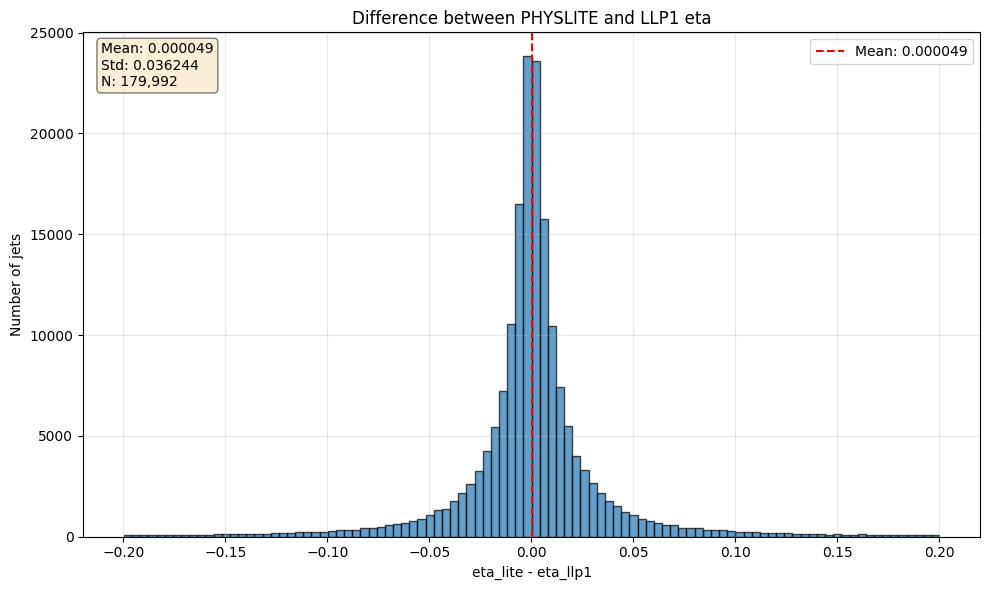

Eta difference statistics:
  Mean: 0.000049
  Std: 0.036244
  Min: -0.199758
  Max: 0.199927


In [3]:
import matplotlib.pyplot as plt

# Calculate eta difference
eta_diff = combined.eta_lite - combined.eta_llp1

# Create the plot
plt.figure(figsize=(10, 6))
plt.hist(ak.to_numpy(eta_diff), bins=100, edgecolor='black', alpha=0.7)
plt.xlabel('eta_lite - eta_llp1')
plt.ylabel('Number of jets')
plt.title('Difference between PHYSLITE and LLP1 eta')
plt.grid(True, alpha=0.3)

# Add statistics to the plot
mean_diff = ak.mean(eta_diff)
std_diff = ak.std(eta_diff)
plt.axvline(mean_diff, color='red', linestyle='--', label=f'Mean: {mean_diff:.6f}')
plt.text(0.02, 0.98, f'Mean: {mean_diff:.6f}\nStd: {std_diff:.6f}\nN: {len(eta_diff):,}',
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.legend()
plt.tight_layout()
plt.show()

print(f"Eta difference statistics:")
print(f"  Mean: {mean_diff:.6f}")
print(f"  Std: {std_diff:.6f}")
print(f"  Min: {ak.min(eta_diff):.6f}")
print(f"  Max: {ak.max(eta_diff):.6f}")

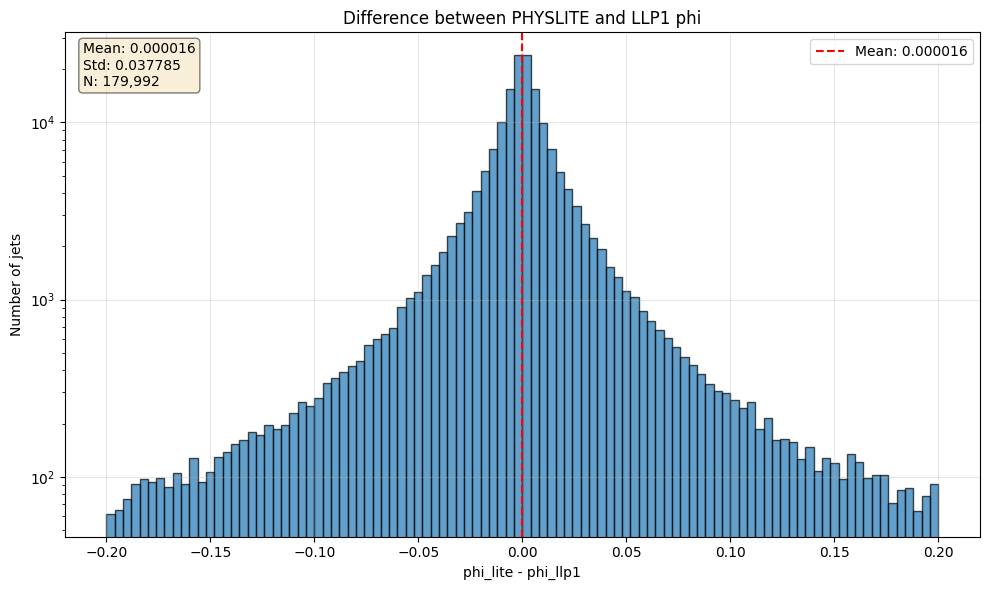

Phi difference statistics:
  Mean: 0.000016
  Std: 0.037785
  Min: -0.199992
  Max: 0.199971


In [6]:
import matplotlib.pyplot as plt

# Calculate phi difference
phi_diff = combined.phi_lite - combined.phi_llp1

# For entries larger than 2*pi, subtract 2*pi
phi_diff = ak.where(phi_diff > np.pi, phi_diff - 2 * np.pi, phi_diff)
phi_diff = ak.where(phi_diff < (-np.pi), phi_diff + 2 * np.pi, phi_diff)


# Create the plot
plt.figure(figsize=(10, 6))
plt.hist(ak.to_numpy(phi_diff), bins=100, edgecolor='black', alpha=0.7)
plt.xlabel('phi_lite - phi_llp1')
plt.ylabel('Number of jets')
plt.yscale('log')
plt.title('Difference between PHYSLITE and LLP1 phi')
plt.grid(True, alpha=0.3)

# Add statistics to the plot
mean_diff = ak.mean(phi_diff)
std_diff = ak.std(phi_diff)
plt.axvline(mean_diff, color='red', linestyle='--', label=f'Mean: {mean_diff:.6f}')
plt.text(0.02, 0.98, f'Mean: {mean_diff:.6f}\nStd: {std_diff:.6f}\nN: {len(phi_diff):,}',
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.legend()
plt.tight_layout()
plt.show()

print(f"Phi difference statistics:")
print(f"  Mean: {mean_diff:.6f}")
print(f"  Std: {std_diff:.6f}")
print(f"  Min: {ak.min(phi_diff):.6f}")
print(f"  Max: {ak.max(phi_diff):.6f}")

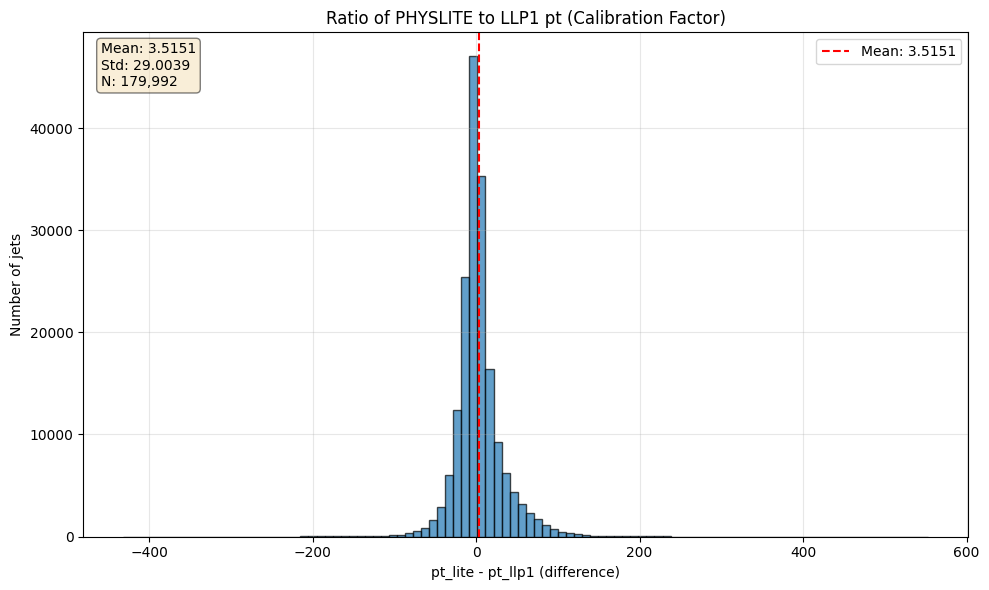

PT ratio (difference) statistics:
  Mean: 3.5151
  Std: 29.0039
  Min: -431.3155
  Max: 552.8648


In [22]:
import matplotlib.pyplot as plt

# Calculate pt ratio (calibration factor)
pt_ratio = combined.pt_lite - combined.pt_llp1

# Create the plot
plt.figure(figsize=(10, 6))
plt.hist(ak.to_numpy(pt_ratio), bins=100, edgecolor='black', alpha=0.7)
plt.xlabel('pt_lite - pt_llp1 (difference)')
plt.ylabel('Number of jets')
# plt.yscale('log')
plt.title('Ratio of PHYSLITE to LLP1 pt (Calibration Factor)')
plt.grid(True, alpha=0.3)

# Add statistics to the plot
mean_ratio = ak.mean(pt_ratio)
std_ratio = ak.std(pt_ratio)
plt.axvline(mean_ratio, color='red', linestyle='--', label=f'Mean: {mean_ratio:.4f}')
plt.text(0.02, 0.98, f'Mean: {mean_ratio:.4f}\nStd: {std_ratio:.4f}\nN: {len(pt_ratio):,}',
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.legend()
plt.tight_layout()
plt.show()

print(f"PT ratio (difference) statistics:")
print(f"  Mean: {mean_ratio:.4f}")
print(f"  Std: {std_ratio:.4f}")
print(f"  Min: {ak.min(pt_ratio):.4f}")
print(f"  Max: {ak.max(pt_ratio):.4f}")


Lets dump a table of the first several pT's just to see what this difference looks like.

In [9]:
import pandas as pd

# Create a nice table showing the first 20 jets
n_jets = min(20, len(combined))

table_data = {
    'Jet #': range(1, n_jets + 1),
    'Run': ak.to_numpy(combined.runNumber[:n_jets]),
    'Event': ak.to_numpy(combined.eventNumber[:n_jets]),
    'pT (LLP1) [GeV]': ak.to_numpy(combined.pt_llp1[:n_jets]),
    'pT (PHYSLITE) [GeV]': ak.to_numpy(combined.pt_lite[:n_jets]),
    'Ratio (LITE/LLP1)': ak.to_numpy((combined.pt_lite / combined.pt_llp1)[:n_jets]),
    'Δη': ak.to_numpy((combined.eta_lite - combined.eta_llp1)[:n_jets]),
    'Δφ': ak.to_numpy((combined.phi_lite - combined.phi_llp1)[:n_jets]),
}

df = pd.DataFrame(table_data)

# Format the dataframe for better display
pd.options.display.float_format = '{:.4f}'.format
df_display = df.style.format({
    'pT (LLP1) [GeV]': '{:.2f}',
    'pT (PHYSLITE) [GeV]': '{:.2f}',
    'Ratio (LITE/LLP1)': '{:.4f}',
    'Δη': '{:.6f}',
    'Δφ': '{:.6f}',
}).set_properties(**{
    'text-align': 'right'
}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold')]}
])

print(f"First {n_jets} jets comparison:")
print(f"{'='*100}")
display(df_display)

print(f"\n{'='*100}")
print(f"Summary statistics for these {n_jets} jets:")
print(f"  Mean pT (LLP1):     {df['pT (LLP1) [GeV]'].mean():.2f} GeV")
print(f"  Mean pT (PHYSLITE): {df['pT (PHYSLITE) [GeV]'].mean():.2f} GeV")
print(f"  Mean calibration factor: {df['Ratio (LITE/LLP1)'].mean():.4f} ± {df['Ratio (LITE/LLP1)'].std():.4f}")
print(f"  Mean Δη: {df['Δη'].mean():.6f} ± {df['Δη'].std():.6f}")
print(f"  Mean Δφ: {df['Δφ'].mean():.6f} ± {df['Δφ'].std():.6f}")


First 20 jets comparison:


,Jet #,Run,Event,pT (LLP1) [GeV],pT (PHYSLITE) [GeV],Ratio (LITE/LLP1),Δη,Δφ
0,1,450000.000000,38130.000000,62.39,30.95,0.4960,-0.077252,0.164224
1,2,450000.000000,38068.000000,50.57,16.46,0.3255,-0.019215,-0.199383
2,3,450000.000000,38060.000000,42.54,31.32,0.7361,-0.016953,-0.003217
3,4,450000.000000,38130.000000,136.24,126.21,0.9264,-0.009939,-0.003359
4,5,450000.000000,38149.000000,94.12,58.10,0.6173,0.023382,-0.051075
5,6,450000.000000,38183.000000,47.15,28.16,0.5972,-0.009953,0.004053
6,7,450000.000000,38014.000000,42.80,40.11,0.9371,-0.013602,-0.026198
7,8,450000.000000,38034.000000,69.42,38.27,0.5513,0.012137,0.016190
8,9,450000.000000,38060.000000,40.54,38.09,0.9397,0.002644,-0.008716
9,10,450000.000000,38058.000000,41.32,21.01,0.5084,0.124440,-0.075031



Summary statistics for these 20 jets:
  Mean pT (LLP1):     118.79 GeV
  Mean pT (PHYSLITE): 98.17 GeV
  Mean calibration factor: 0.7271 ± 0.2246
  Mean Δη: -0.006405 ± 0.048006
  Mean Δφ: -0.014250 ± 0.075603


The differences seen here are dramatic. So large I don't trust them.

In [10]:
## Looking at the raw, uncombined, data

l_physlite = ak.from_parquet("../runit_PHYSLITE.parquet")
l_llp1 = ak.from_parquet("../runit_LLP1.parquet")

In [17]:
l_p = l_physlite[l_physlite.eventNumber == 38130]
l_l = l_llp1[l_llp1.eventNumber == 38130]

In [19]:
# Build and display the table
df_lp = pd.DataFrame({
    "phi": ak.to_numpy(l_p.phi),
    "eta": ak.to_numpy(l_p.eta),
    "pt": ak.to_numpy(l_p.pt),
})

In [20]:
df_ll = pd.DataFrame(
    {
        "phi": ak.to_numpy(l_l.phi),
        "eta": ak.to_numpy(l_l.eta),
        "pt": ak.to_numpy(l_l.pt),
    }
)
df_ll

,phi,eta,pt
0,0.1935,-2.2703,136.2354
1,-2.9843,-1.6932,121.1642
2,-2.4528,-1.6214,62.3916


In [21]:
df_lp

,phi,eta,pt
0,-2.9193,-1.6749,149.8996
1,0.1901,-2.2803,126.2092
2,-2.2885,-1.6987,30.9492


Next, we should look to see if the provenance is right, because... WTF, man!